# Deconvolution using Flowdec

For more information see https://github.com/hammerlab/flowdec

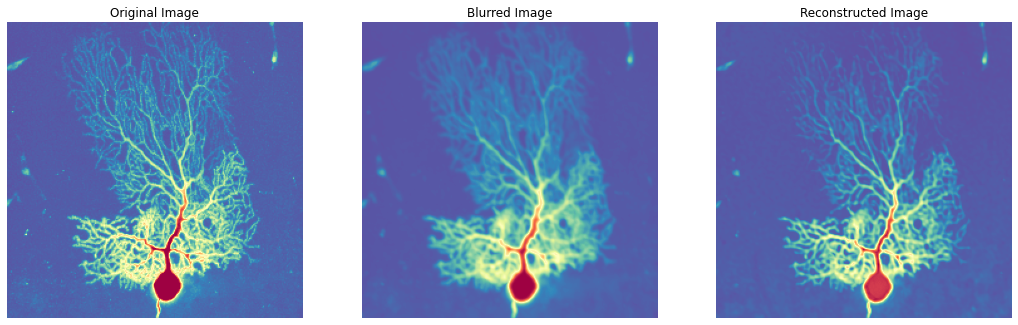

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy import ndimage, signal
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration

# Load "Purkinje Neuron" dataset downsampled from 200x1024x1024 to 50x256x256
# See: http://www.cellimagelibrary.org/images/CCDB_2
actual = fd_data.neuron_25pct().data
# actual.shape = (50, 256, 256)

# Create a gaussian kernel that will be used to blur the original acquisition
kernel = np.zeros_like(actual)
for offset in [0, 1]:
    kernel[tuple((np.array(kernel.shape) - offset) // 2)] = 1
kernel = ndimage.gaussian_filter(kernel, sigma=1.)
# kernel.shape = (50, 256, 256)

# Convolve the original image with our fake PSF
data = signal.fftconvolve(actual, kernel, mode='same')
# data.shape = (50, 256, 256)

# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim).initialize()
res = algo.run(fd_data.Acquisition(data=data, kernel=kernel), niter=30).data

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
fig.set_size_inches(18, 12)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Blurred Image', 'Reconstructed Image']
for i, d in enumerate([actual, data, res]):
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')